# Intro
My data analysis will predict the direction of the S&P 500 Index

# Import

In [139]:
import datetime
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

In [140]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period = "max")
sp500.to_csv("/Users/tgut03/Jupyter/Data/sp500 Index.csv")

# Transform

In [141]:
# Convert Data Types
sp500.index = pd.to_datetime(sp500.index, utc = True)
sp500.index = sp500.index.date

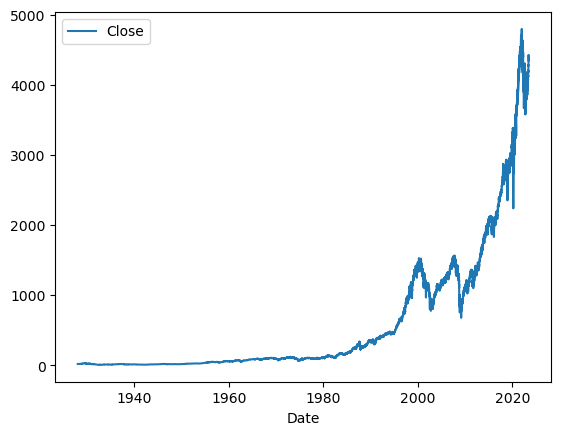

In [142]:
# Time Series
sp500.plot(kind = "line", y = "Close", use_index = True)
plt.xlabel("Date")
plt.show()

In [143]:
# Remove Cols
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500

,Open,High,Low,Close,Volume
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2023-06-16,4440.950195,4448.470215,4407.439941,4409.589844,6848600000
2023-06-20,4396.109863,4400.149902,4367.189941,4388.709961,4055790000
2023-06-21,4380.009766,4386.220215,4360.140137,4365.689941,3709330000
2023-06-22,4355.399902,4382.250000,4351.819824,4381.890137,3511000000


In [144]:
# Tomorrow = Close - 1
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [145]:
# If Up Then 1 Else 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [146]:
# Get Date After Jan 1990
date = datetime.date(1990, 1, 1)
sp500 = sp500[sp500.index >= date].copy()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-06-16,4440.950195,4448.470215,4407.439941,4409.589844,6848600000,4388.709961,0
2023-06-20,4396.109863,4400.149902,4367.189941,4388.709961,4055790000,4365.689941,0
2023-06-21,4380.009766,4386.220215,4360.140137,4365.689941,3709330000,4381.890137,1
2023-06-22,4355.399902,4382.250000,4351.819824,4381.890137,3511000000,4348.330078,0


In [147]:
# Split Dataset
train = sp500.iloc[:-100]
test = sp500[-100:]

In [148]:
# Select Features
predictors = ["Open", "Close", "High", "Low", "Volume"]

# Model

In [149]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score

In [150]:
# Model
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)

In [151]:
# Train Model
model.fit(train[predictors], train["Target"])
print("Success")

Success


In [152]:
# Predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)

In [153]:
# Precision
score = precision_score(test["Target"], preds)
print(f"1 = {score.round(2)}")

1 = 0.61


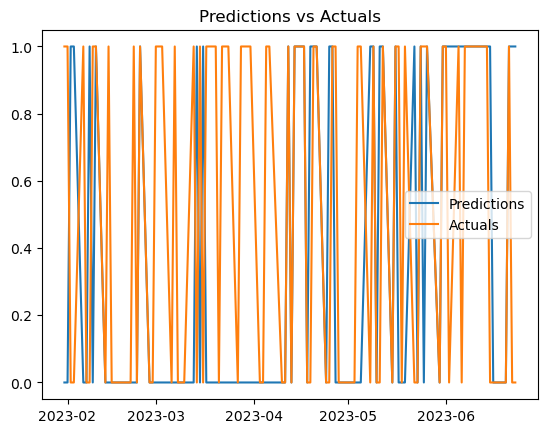

In [154]:
# Predictions Actuals Concatenation
preds = pd.Series(preds, index = test.index)
predsActs = pd.concat([preds, test["Target"]], axis = 1)

# Plot Precision
predsActs.plot(kind = "line")
plt.title("Predictions vs Actuals")
plt.legend(["Predictions", "Actuals"])
plt.show()

In [155]:
# Predict Function
def predict(train, test, predictors, model) :
    model.fit(train[predictors], train["Target"]) # Train Model
    preds = model.predict(test[predictors]) # Predictions
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsActs = pd.concat([preds, test["Target"]], axis = 1) # Predictions Actuals Concatenation
    return predsActs

In [156]:
# Backtest Function
def backtest(data, predictors, model, start = 2500, step = 250) : # 1yr = 250
    allPreds = []
    
    for i in range(start, data.shape[0], step) :
        train = data.iloc[0:i].copy() # Train
        test = data.iloc[i:(i+step)].copy() # Test
        newPreds = predict(train, test, predictors, model) # Predict Function
        allPreds.append(newPreds) # Append Predictions
    return pd.concat(allPreds)

In [157]:
# Predictions Frequency
newPreds = backtest(sp500, predictors, model)
newPreds["Predictions"].value_counts()

0    3389
1    2545
Name: Predictions, dtype: int64

In [158]:
# Precision
score = precision_score(newPreds["Target"], newPreds["Predictions"])
print(f"1 = {score.round(2)}")

1 = 0.53


In [159]:
# Actuals
(newPreds["Target"].value_counts() / newPreds["Predictions"].shape[0]).round(2)

1    0.53
0    0.47
Name: Target, dtype: float64

In [160]:
# History Function
horizons = [2, 5, 60, 250, 1000]
newPredictors = []

for horizon in horizons : 
    rollAvgs = sp500.rolling(horizon).mean()
    
    ratio = f"{horizon} Day Close Ratio"
    sp500[ratio] = sp500["Close"] / rollAvgs["Close"]
    
    trend = f"{horizon} Day Trend"
    sp500[trend] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    newPredictors += [ratio, trend]

In [161]:
# Remove Nulls
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,2 Day Close Ratio,2 Day Trend,5 Day Close Ratio,5 Day Trend,60 Day Close Ratio,60 Day Trend,250 Day Close Ratio,250 Day Trend,1000 Day Close Ratio,1000 Day Trend
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-15,4365.330078,4439.200195,4362.600098,4425.839844,4176690000,4409.589844,0,1.006052,2.0,1.014857,5.0,1.066704,35.0,1.110229,120.0,1.171738,537.0
2023-06-16,4440.950195,4448.470215,4407.439941,4409.589844,6848600000,4388.709961,0,0.998161,1.0,1.006023,4.0,1.060773,35.0,1.105338,119.0,1.166977,536.0
2023-06-20,4396.109863,4400.149902,4367.189941,4388.709961,4055790000,4365.689941,0,0.997627,0.0,0.998990,3.0,1.053891,34.0,1.099416,118.0,1.161007,535.0
2023-06-21,4380.009766,4386.220215,4360.140137,4365.689941,3709330000,4381.890137,1,0.997370,0.0,0.993900,2.0,1.046710,33.0,1.092986,118.0,1.154489,534.0


In [162]:
# Model
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

In [163]:
# Predict Function
def predict(train, test, predictors, model) :
    model.fit(train[predictors], train["Target"]) # Model
    preds = model.predict_proba(test[predictors]) [:,1] # Predictions Probability
    preds[preds >= 0.6] = 1 # Probability Level
    preds[preds < 0.6] = 0 # Probability Level
    preds = pd.Series(preds, index = test.index, name = "Predictions") # Predictions
    predsActs = pd.concat([preds, test["Target"]], axis = 1) # Predictions Actuals Concatenation
    return predsActs

In [164]:
# Predictions Frequency
newPreds = backtest(sp500, newPredictors, model)
newPreds["Predictions"].value_counts()

0.0    4119
1.0     814
Name: Predictions, dtype: int64

In [165]:
# Precision
score = precision_score(newPreds["Target"], newPreds["Predictions"])
print(f"1 = {score.round(2)}")

1 = 0.57


In [166]:
# Actuals
(newPreds["Target"].value_counts() / newPreds["Predictions"].shape[0]).round(2)

1    0.54
0    0.46
Name: Target, dtype: float64

# Conclusion
My model correctly predicted the sp500 Index would go up 57% of the days, while the sp500 Index went up 54% of the days. Therefore, we can conlude the model has 3% predictive ability compared to the sp500 Index. The next steps for this model would be to implement additional features such as market sentiment, sector performance, or company fundamentals to improve model precision